In [1]:
from bs4 import BeautifulSoup
from __future__ import (absolute_import,
division,
print_function,
unicode_literals)
from IPython.display import Image
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from operator import add
from twython import TwythonStreamer
from pyspark import SparkContext
import glob, datetime, string,  os ,os.path, pymongo, re, time, sqlite3, urllib2 
#IPYTHON_OPTS='notebook' . /usr/local/bin/pyspark 

In [2]:
stop = stopwords.words('english')
cwd = os.getcwd()
stemmer =PorterStemmer()

# Classifying Streaming Tweets in Real-Time


# Company Name:

###  CardDex: A Text Classification Company
(Jaccard Index)

# Problem statement:
How can I accurately classify text? 

How about if they are streaming? 

How do you store it?

We accurately sort and group text documents for you so you don't have to.

# Solution:
Break down and tokenize words in documents and find distinct words per group and create similarities.

# Real World Problem/ Business Model:

Sorting through immigrant documents is very difficult and time consuming.  Using tweets as a proof of concept, I was able to classify streaming tweets using the bag of words concept and jaccard similarity.  Eventually, I would like to expand this idea for my capstone project.     


# Architecture diagram:

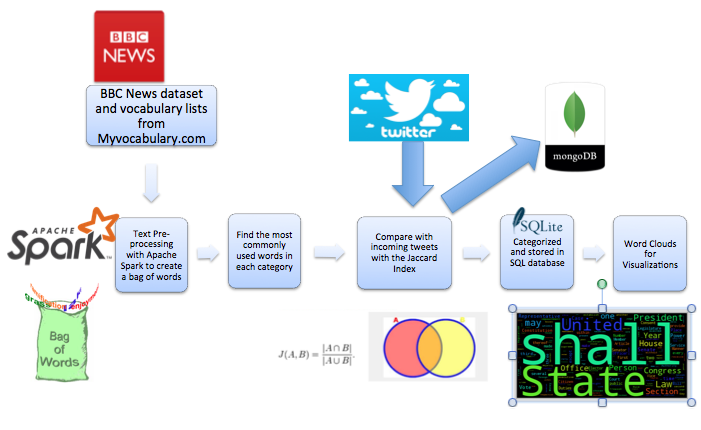

In [3]:
Image("flowchart.png")

# Note:
    
For the project, I picked two different storage systems.  For my capstone project or writing production code, I would pick one or the other.  In this case, I would pick MongoDB because it is much more easier to query and it is not restricted to a schema.  

Sources of photos:

http://www.tutorialsarea.com/cseit/mongodb/MongoDB-Java.html

http://www.python-course.eu/text_classification_python.php

http://spark.apache.org/

http://bbc.com

http://twitter.com

https://www.sqlite.org/

https://github.com/amueller/word_cloud

https://axialcorps.com/2015/05/01/industry-similarity-via-jaccard-index/

# Data Types:

1)Static Data: Curated Articles from a BBC insights dataset http://mlg.ucd.ie/datasets/bbc.html . The categories: tech, business, sports, politics, entertainment were already defined.  Vocabulary lists from a beautifulsoup scrape. 

2)Streaming Data: Twitter Tweets

# Technologies:

1)Spark

2)SQL Lite

3)Twitter Steaming Twython package

4) MongoDB

# Premortem:

- Kernel crashes quite often
- tweets are sometimes misclassified

# Challenges:

- finding clean data with clean words
- using distributed data solutions to do the work for me
- mixing streaming and static data together
- getting a sql database to store my data
- accurately classifying tweets
- encoding utf-8 and anscii from raw text

# At first....
- tried Doc2vec, TFIDF, but turned into a NLP project fast, so I abandoned the idea

# Learning:

- sqlite3, Twython 

# If I had more time:
- Move my code to a dedicated server such as EC2 or databricks solution 
- get a timer for my working stream
- optimize code for production
- probabalistic spell corrector

# If I could do things differently:

- focus on a few specific sports since the words and language can vary greatly depending on the activity.  It may be good to classify between specific sports.


# If I had a magic wand to make any technology work:
- Kafka hands down because I could not get that to work on my computer. 

# Removing Puncuation

In [16]:
def removePunctuation(text):
    ''''
    removes punctuation in all words and lowers as well
    
    '''

    for c in string.punctuation:
        text = text.replace(c,"").strip().lower()
    return text

# punctuation is in the text in anyway it is replaced,stripped, and lowered

# Redundant words

In [5]:
top_redundant = ['allow','made','show','local','report','next','go','week','come','last','ad','two','also','take','new','world','peopl',
                 'like','want','would','make','say','could','us','uk','england','one','year','said',
                 'get','mr','time','first','bbc','need','well','help','day',
                 'back','home','number','three','mani','think','way','see',"''",'told','call','month','meet']

# redundant words that ended up being in the top, will be removed in the comparisons

# Cleaning Article Words

In [6]:
def toparticlewords(n):
    
    ''''
    creating a bag of words and taking
    the top 75 words used in each category 
    
    '''
    wordfile = (sc
                 .textFile('file://' + cwd + n)
                 .flatMap(lambda row: row.split(" "))
                 .map(lambda word: removePunctuation(word))
                 .filter(lambda word: word not in stop)
                 .filter(lambda word: word != '')
                 .filter(lambda word: word not in top_redundant)
                 .map(lambda word : stemmer.stem(word)))
    #split, remove punctuation, removing stop words, removing quotes, removing redundant words
    #and stemming with a porter

    topWords = (wordfile
                .map(lambda x: (x,1))
                .reduceByKey(add)
                .takeOrdered(75, key=lambda x: -x[1]))
    
    #finding the top words using counts

    topWords = (sc.parallelize(topWords)
                .map(lambda x : x[0])
                .collect())
    
    # removing the count and just keeping the top words
    return topWords

# Different Categories

In [7]:
topsportWordsAndCounts = toparticlewords('/sportfile.txt')
toptechWordsAndCounts = toparticlewords('/techfile.txt')
topbusinessWordsAndCounts = toparticlewords('/businessfile.txt')
topentertainmentfileWordsAndCounts = toparticlewords('/entertainmentfile.txt')
toppoliticsWordsAndCounts = toparticlewords('/politicsfile.txt')

# originally I wanted to do more categories, but chose to do less

In [25]:
politicsbusiness_  = list(set(toppoliticsWordsAndCounts + [ 'Media' , 'NRA' , 'islamic', "Extremist" , "Islamist" ,'Turkey' , 'Coup', 'LEADERSHIP','Legal', 'America', 'Prosecutor' , 'poll', "Liberal" , "Democracy" ,"vetted" , "minister" , "Pres", "Bernie", "Sanders", "endorse" ,"Hillary", "Clinton" ,"parliament","parliamentary" , "economy", "conservative" , "May" , 'courthouse', 'referendum', 'democrat' ,'taxpayer', 'oil', 'president', '9/11' ,'activist' ,'Qaeda' , 'democracy', 'Presidential', 'Amendment' , '@ccnbrk' , 'taxpayers ' , 'Independent' , 'Nato' ,'politicians','news','manipulation','WMD','reelected','HILLARY' ,'sanction' ,'fraud' ,'socialist', 'Taliban', 'intelligence' ,'putin','democracy' ,'regulations' ,'GOP', 'lawsuit', 'people', 'nazis', 'Israel', 'clinton', 'Palestine' ,'lie' ,'lying' ,'lies', 'political' ,'Saddam' ,'Hussein' ,'FBI','corrupt' ,'corruptable', 'Hillary','trial' , 'ISIS','indict', 'china','environment','election','obama','bush','donate','email','charity' , 'rate','bernie','sanders','berniesanders','law','Clinton','FBI','vote', 'brexit' , 'hillary' , 'democracy' , 'trump' , 'president', 'republican','prison']))

In [26]:
violence = 'victim mess armed robbery ambushing TERROR gunman hostages poison bigots Militarized tragic tragedy shot shit sniper shooters cop army terrorist civil attack protest weak yuck ugh fake sellout arrest bullshit ugly traitor pussy gross investigation sucks terror stupid batter batterer racist irrelevant slap slapping asshole ignorant SHOOTINGS injustice terrorism punish trash fag CHEATED cheat VIOLATED violate harass homicide drown evil fatality fatal shut punish coward marine vile criminal armed dangerous danger secrets fatal murder offender offend Cops resist scumbag prick shame disgust pedophilia criminal torture horrible terrible Strip arrest haters hack crime dying oppression bloody rapist molester kick bitch barrage died racist douche fuck thug destruction blame assault targeted evil loot police tyranny R.I.P. stab strike crash Aggressor, Agitator, Aim, Alert, Ambush, Ammunition, Anarchy, Anguish, Annihilate, Apartheid, Arms, Arsenal, Artillery, Assassin, Assassinate, Assault, Atrocity, Attack, Authority, Automatic Barrage, Barricade, Battle, Battlefield, Belligerent, Betrayal, Blast, Blindside, Blood, Bloody, Bomb, Bombardment, trap, Breach, Break, Brutal, Brutality, Brute, Bullet, Bully, Burn Cadaver, Camouflage, Campaign, Captive, Capture, Careen, Carnage, Casualties, Cataclysm, Causes, Chaos, Charge, Charred, Clandestine, Clash, Coalition, Collapse, Combat, Commandos, Concussion, Conflagration, Conflict, Confrontation, Conquer, Consequences, Consolidate, Conspiracy, Conspire, Control, Coordinates, Corpse, Counterattack Crash, Crime, Crisis, Cross-hairs, Culpability Damage, Danger, Dangerous, Dash, Dead, Deadly, Death, Debacle, Deception, Deliberate, Demolish, Demoralize, Despot, Destroy, Destruction, Detect, Detection, Devastation, Device, Dictator, Dictatorship, Die, Disarmament, Disaster, Disastrous, Discipline, Disease, Dispute, Disruption, Dissonance, Division, Domination, Doom, Downfall, Drama, Dread Encounter, Enemy, Enforce, Engagement, Epithet, Escalate, Excess, Execute, Execution, Explode, Exploitation, Explosion, Explosive, Expunge, Extremism Faction, Fanatic, Fatal, Fear, Fearful, Felon, Ferment, Ferocious, Feud, Fierce, Fiery, Force, Forceful, Forces, Fray, Frenzy, Front lines, Fuel, Fugitive, Furtive Gang, Gang up on, Gas, Genocide, Germ warfare, Grave, Grenade, Grievous, Groans, Guard, Guerrillas, Guided bombs, Guns, Gunship Hammering, Harass, Harsh, Hatch, Hate, Hatred, Hazard, Hiding, Hijack, Hijacker, Hit, Hit-and-run, Holocaust, Horror, Hostility, Howitzer, Hurt Ignite, Impact, Improvise, Incident, Incite, Incontrovertible, Infanticide, Infiltrate, Inflame, Informant, Injuries, Inmate, Insurgent, Insurrection, Intense, Intercept, Interdiction, International, Interrogation, Intervene, Intimidate, Invasion, Investigate, Investigations, Involvement, Ire Jail, Jeer, Jets Kamikaze, Keen, Kidnap, killed kills kill Killing, Knife, Land bomb Loathsome guns, Maim, Malevolent, Malicious, Maraud, March, Massacre, Mayhem, Megalomania, Menace, Militancy, Militant, Militaristic, Military, Militia, Mines, Missile, Mission, Mistreatment, Mob, Mobile, Mobilization, Momentum, Mortars, Munitions, Murder Nationalist, Neutralize, Nightmare Notorious Offensive, Onerous, Operation, Opposition, Order Outbreak, Overthrow Partisan, Patrol, Penetrate Persecute, Petrify Pistol Plunder traumatic, Potent, Preemptive, Premeditate, Prey Proliferation, Provocation, Prowl, Pugnacious, Pulverize, Pushing Quail, Quarrel, Quell, Quiver Radiation, Radical, Rage, Ravage, Ravish, Rebel, Rebellion, Reconnaissance, Refugee, Regime, Regiment, Reinforcements, Relentless, Reparation, Reprisal, Reputation, Resistance, Retaliation, Retreat, Retribution, Revenge, Revolution, Ricochet, Rifle, Rift, Riot, Rival, Rot, Ruthless Sabotage, Sacrifice, Salvage, Savage, Scare, Scramble, Secrecy, Secret, Sedition, Seize, Seizure, Shock shot shoot Siege, Skirmish, Slaughter, Smash, Smuggle, Soldier, Special-ops Spy, satellite Stalk, Stash, Stealth, Storm, Straggler, Strangle Strife, Strike, Strip, Stronghold, Struggle, Subversive, Suffering, Suspect Tactics, Tank, Target, Tension, Terror, Terrorism, Terrorist, Terrorize, Threaten, Thug, Thwart, Topple, Torch Tourniquet, Trample, Trap, Trauma, Treachery, Trench, Trigger, Triumph, Tsunami, Turbulent Uprising Vendetta, Venomous, Vicious Violence, Virulence, Vital, Vitriol, Vociferous, Void, Vow, Vulnerability Wage, War, Warheads, Warplane, Warrant Weapon, Wound, Wreckage'


In [27]:
def toparticleword(n):
    '''
    cleans the list of words I scraped from the internet
    
    '''

    wordfile = (sc
                 .parallelize(n.split(" "))
                 .map(lambda word: removePunctuation(word))
                 .filter(lambda word: word not in stop)
                 .filter(lambda word: word != '')
                 .map(lambda word : stemmer.stem(word.lower())).collect())
    
    # variation created for vocabulary lists that I scraped from the internet
    
    return wordfile

In [28]:
violence_words = list(set(toparticleword(violence)))
# only want unique words

In [29]:
sports1 = 'practice spectators UEFA FIFA field rookie career football trophies trophy goal prospect slugger TKO round Nascar Gold amateur draft trade College Football Playoff competition quarter-final Boxing MVP sportscard golfer Cubs athletes Ronaldo Messi Serena Celtics Williams 400m Uniform volleyball match set Murray @BleacherReport champ Wimbledon Superbowl Winnipeg NCAA pro footballer professional title court Lesnar sport bandwagon kobe bryant jordan Messi semis SportsCenter BBCsport Murray vick Wimbledon WWE contest Kerr derby grand prix F1 tournament deal ESPN Wade wimbeldon mvp hoops stats, All-Stars, stars All-Star , roster, NL game, accurate , foul FT agent okc fan LeBron parade kd curry kevin durant trade cavs warriors aerobic alpine skiing  alternate  announcement  applause  arrangements  assist  assistance  athlete  attendance  attraction  averages balance   biathletes  bicycle  bid   bobsled  bronze medal silver gold buzzer captivate champion cardiovascular  categories  ceremony   champion  championship  charisma  charm  clapping  coaches  collapse  commitment  competition  conditioning  conference  contingencies  conversion  convert  coordination  countries  courage  creativity  curfew  curling  curling  cycled delegation  descent  diet  disqualification  endurance  energy exercise  exertio  finals  fit  flags  flex freestyle skiing  games slalom  goal  gold medal  grip guidelinesh halfpipe  health  healthy  hockey  hygiene dancing  ice hockey  ice skating individual injury jump  league  legend  losing  loss  lucky  luge  lumbarm magic  manager  margin  mascot  massage  maximize  measure  medal  media  medical  medication  memory  metabolic minimize  miss  moguls  moisture  moisturize  monitor  motivate  motivation  muscles nurse offense opening ceremony  paralympics  participation  pass  penalties  percentage  perform  performance  perimeter  perspiration  pessimism  petrify  physiotherapy points possession  potent practice  preparation  prevention  profile promising quads  quality  quest  quick quiver ranking  recognition  record  recovery  recruit  regulations  rehabilitation reserve  resilient role  score  scoreboard  scoring  season  security  sensible  shape  short track speed skating silver medal skating  skeleton  ski jumping  skiing  slide  slope snowboard  speculation  sports  sportsmanship  squad  squat  stability  stadium  stamina  standings  statistics strategy  streak  strength  stretch  stride  strong supremacy  suspension  symptoms team teammate  technical test  therapeutic  therapy  tickets  timeout  timing  tone  torch  torso  trainer  training  transformation  tremors unbelievable  underscore unrestricted  unusual vaccination valiant  valor  vault  venue  vibration  victory  violation warm up  watchful  weary  weigh  weights  win  winning yards  yoga'
sports2 = 'postseason leaderboard UFC MMA Olympian swimmer duncan finals competitive @BBCSport Nash OKC train 1500m  routine Gym crossfit watch watching watched defeat Scores roster marathon nfc bbctennis rugby MLB backboard, player, Venus Williams advanced semifinal cheerleader rim assists arena trade Frank Mir WNBA RINGS nba  league NASCAR acrobatics  aerobics  aikido  archery  arts and crafts  auto cross  auto racing  auto rally badminton  baseball  basketball  beach volleyball  biathlon  bicycling  billiards  bobsledding  bocce  bowling  boxing calisthenics  camping  canoeing card games  cricket  croquet cross skiing curling  cycling decathlon  discus  distant diving  dodge ball  dog racing  downhill skiing  dressagee equestrian fencing  field and track  field hockey  figure skating  fishing  fitness walking  flag football  fly fishing  football go carting  golf  gymnastics half marathon  hammer throw  handball  handball  hang gliding  high jumping  hiking  hockey  horse racing  horseback riding  horseshoes  hunting  hurling ice dancing  ice hockey  ice skating  line skating jacks javelin throw  jet skiing  jogging  judo karate  kayaking  kickboxing boxing lacrosse  lawn bowling jump  lugem mah jong  marathon  martial arts  motocross  motorcycling  mountain climbing olympics open water swimming poker  pole vault  polo  pool boating lifting walk racket ball  relay  road rodeo circuit  roller skating  rowing  rugbys sailing diving shuffleboard  skateboarding  skeet skiing  skin diving  slalom  sled dog racing  sledding  snorkeling  snowboarding  snowmobiling  soccer  softball  spinning  squash  stock car racing  sumo wrestling  surfing  swimming table tennis  table tennis  tae kwon do tennis  tobogganing  tournaments  track  track and field  trail sled dog racing  triathlon  trivia contests vaulting  volleyball  volleyball water polo  water skiing  wave weight training  weightlifting  wiffle ball  wind surfing  wrestling xtreme sportsy yachting  yoga Wimbledon ball Tour de France golf semi-finals finals nba 100m 400m swim Gymnastics Diving injury injuries Track Field series karate kayak join fitness sport Coach teammates captain contest agent contract 400m 200m archer sprint trade NBA pitch season title 800m ping pong trophy UFC offer set final play train compeition compete athletic GSW'

In [30]:
sport = sports1+sports2

In [31]:
sport_words = list(set(toparticleword(sport) +topsportWordsAndCounts))
# unique words in sports, combining mined words from bbc articles and vocabulary lists online

In [32]:
#sport_words

In [33]:
# url = urllib2.urlopen('https://myvocabulary.com/word-list/politics-vocabulary/')

# soup = BeautifulSoup(url)

# soup.text.replace

# Setting Up SQLite

In [34]:
conn = sqlite3.connect('Twittertweet.db')
#launching the sqlite table
c = conn.cursor()
c.execute('CREATE TABLE if not exists Twitter_table (time, category, tweet)')
# if the table doesn't exist, the create the table
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
#breaking up the timestamp 


# Setting Up PyMongo

In [35]:
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017/')
# launching mongo
db = client.test
#launching a test case
db.Twitterdb
# creating a twitter table

Collection(Database(MongoClient(host=[u'localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'test'), u'Twitterdb')

# Twitter SQLite Stream Code:

In [36]:
class MySQLStreamer(TwythonStreamer):
    '''
    my stream collects text, classifies it, stores it in a sql table
    input: Twitter Stream
    output: categorized data
    '''
    
    def on_success(self, data):
        
        if 'text' in data:
            text = data['text'].encode('ascii' ,"ignore" ).encode('utf-8','ignore')
            # dealing with the unicode
            if text[:2] != 'RT':
                #getting rid of retweets
                
                tweet =(sc.parallelize(str(text).split(' '))
                        .map(lambda word: removePunctuation(word))
                        .map(lambda word : stemmer.stem(word)).collect())
                # bag of words with pyspark and stemming with nltk

                violence_ = len(set(tweet).intersection(violence_words)) / len(set(tweet).union(violence_words))
                sport_ = len(set(tweet).intersection(sport_words)) / len(set(tweet).union(sport_words))
                business_and_politics_ = len(set(tweet).intersection(politicsbusiness_)) / len(set(tweet).union(politicsbusiness_))
                # doing a jaccard index with the 3 different categories
                
                d = {'agressive': violence_ , 'sport': sport_ , 'politics':business_and_politics_}
                if sum(d.values()) == 0.0:
                    #if there is no score in any of the categories, it is categorized as other
                    print ("Other" , text)
                    # nice print out of other
                    c.execute("INSERT INTO Twitter_table (time, category, tweet) VALUES(?,?,?)",((timestamp).encode('utf-8'),("Other").encode('utf-8') , text.encode('utf-8')))
                    # inserting into sqlite table and committing
                    conn.commit()
                    

                else:
                    
                    print (max(d, key=d.get),text)
                    
                    c.execute("INSERT INTO Twitter_table (time, category, tweet) VALUES(?,?,?)",(timestamp.encode('utf-8'),max(d, key=d.get).encode('utf-8'),text.encode('utf-8')))
                    # category with the highest jaccard index score will be named with the max function
                    # inserting into sqlite table and committing
                    conn.commit() 
                    

    def on_error(self, status_code, data):
        print (status_code)

In [37]:
twitter_id = {'23484039':'@WSJbreakingnews','5402612': '@BBCBreaking',
             '6017542': '@BreakingNews','86141342': '@ABCWorldNews',
             '11855772': 'NBCNewsWorld','3055067522': '@Terror_Monitor',
             '2785269257': '@terrorism_info','7302282':'@YahooSports',
             '14885860':'@CBSSports','1766701':'@NYTSports',
             '265902729': '@BBCSport','2469514160': '@_sports1_',
             '30690661': '@sportingnews','28370738': '@SInow',
             '890891': '@BleacherReport','2557521':'espn',
             '26257166':'@SportsCenter','30690661':'@sportingnews',
             '69956111': '@bbctennis','15108702': '@ReutersLive',
             '18767649':'@CBSTopNews','2673523800':'@AJELive',
             '742143': '@BBCWorld','11856342':'@NBCSports',
             '807095': '@NYTimes','8839632': '@NBCNightlyNews',
             '5402612': '@bbcbreaking','428333': '@cnnbrk',
             '87416722': '@skynewsbreak','19923144':'@NBA',
             '74518740':'@ESPNNBA','1373313666':'@nbacom',
             '296520276' : '@draftkings','26257166' : '@sportscenter',
             '14885860': '@CBSsports','1766701' : '@NYTSports',
             '10222282' : '@latimessports','249249080' : '@xfinitysports',
             '69956111' : '@bbctennis', '108568373':'@skysportsnewshq'}

# The SQLite Stream:

In [40]:
APP_KEY = "Gogm4OEvdvmTAd949zWaLpzW5"

APP_SECRET = "pXUP2ydiFtkgexdKgK7xbzL5mWY3Ai64CrxGbG3lSl62UPW7Dj"
                    
OAUTH_TOKEN = "1922156167-fKDP2wu3pebQGJGbE8BKvMPWJJvygAEz49LH5np"

OAUTH_TOKEN_SECRET = "tW6zCUXUrqMWYhekVrhi5k3DfOTDzjYdUWszmqdxZZ1rC"

# twitter authorization keys
 
try:
    stream = MySQLStreamer(APP_KEY, APP_SECRET,
                  OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    
    stream.statuses.filter(follow=twitter_id.keys())
    # I have accounts from all the major news and and sports outlets such as reuters, ccn, nbc, bbc, espn,
    # sports illustrated, yahoo, yahoo sports
    
except:
    KeyboardInterrupt
# only way to end this stream is to hit stop

sport @NBA @NBASummerLeague @Timberwolves @Suns @cavs @chicagobulls all these dudes have their Irving's on @CruzFrancis14
politics @BBCWorld They might if the cops are fired, prosecuted, retrained and start changing their ways!
politics @BBCWorld @BBCNews it's not gonna stop just like that,the country is deeply divided,too much hate on both sides and too many guns on street
Other @BBCWorld yes.. but not with words... actions.
agressive @nytimes So. Was the Baton Rouge shooter's name Muhammad or Maurice ? My guess is that he doesn't pray towards the East, or know which way
sport @nytimes what was his response to Nice? Trucks trucks trucks time to move to the Arctic?
agressive @BBCBreaking @HuffingtonPost @CNN PLEASE,HELP US SPREAD THS HORROR!PEOPLE WHO IGNORE IT,NEED2KNOW! #stopboknal2015 https://t.co/oQy1RWAtf6
sport @BleacherReport 2021
Other @SkyNewsBreak @5_News @SkyNewsPR https://t.co/w30upTu3ux
politics @cnnbrk What's scary to me Pamela is that law enforcement will continue to mis

# other category

In [39]:
for row in c.execute("SELECT category, time, tweet FROM Twitter_table WHERE category = 'Other' GROUP BY category, time, tweet LIMIT 10"):
    print (row)

(u'Other', u'2016-07-11 10:55:22', u'@ABCWorldNews WP understand #BlueLivesMatter and #AllLivesMatter but not #BlackLivesMatter#BatonRouge @UniteBlueTX https://t.co/A4KdMKKbRh')
(u'Other', u'2016-07-11 10:55:22', u'@ABCWorldNews WP understand #BlueLivesMatter and #AllLivesMatter but not #BlackLivesMatter#BatonRouge @UniteBlueTX https://t.co/UiInFNwEas')
(u'Other', u'2016-07-11 10:55:22', u'@ABCWorldNews WP understand #BlueLivesMatter and #AllLivesMatter but not #BlackLivesMatter#BatonRouge @UniteBlueTX https://t.co/jUHRipbXnN')
(u'Other', u'2016-07-11 10:55:22', u'@BBCBreaking #___ :       \nhttps://t.co/fg4bBqmujT')
(u'Other', u'2016-07-11 10:55:22', u'@BBCBreaking @BBCBusiness @BBCNews @WSJ @USATODAY @USArmy @BritishArmy https://t.co/t5El4CsuEF')
(u'Other', u'2016-07-11 10:55:22', u"@BBCBreaking @BBCNews \nFinally comes the Plaster's Lady to fix the breakdown.")
(u'Other', u'2016-07-11 10:55:22', u'@BBCBreaking @BBCNews Gone by Christmas')
(u'Other', u'2016-07-11 10:55:22', u'@BBCBre

# Other Example:

(u'Other', u'2016-07-11 16:02:43', u'@BBCSport Hahahahahahahahaha')

(u'Other', u'2016-07-11 16:09:11', u'@BBCSport https://t.co/83RSxKbYtL')

(u'Other', u'2016-07-12 11:13:40', u'@espn https://t.co/5FJZWfkZG3')

(u'Other', u'2016-07-11 16:09:11', u'@BBCSport interesting')

(u'Other', u'2016-07-11 16:09:11', u'@BBCWorld @BBCNews  ')

(u'Other', u'2016-07-12 14:43:57', u'@espn \n\nIt execxxx tx5xxxx cx v7k\n\nKinkomn\nn8 1\n\nI kji')

(u'Other', u'2016-07-12 14:43:57', u'@espn @wassimbensliman  00  2ph 6rfudad9')

# sports category

In [38]:
for row in c.execute("SELECT category, time, tweet FROM Twitter_table WHERE category = 'sport' GROUP BY category, time ,tweet LIMIT 10"):
    print (row)

(u'sport', u'2016-07-11 10:55:22', u"@ABCWorldNews #ridiculous..the families should sue #US gov't home security for not weeding out #terrorists from facebook..#CIA is everywhere")
(u'sport', u'2016-07-11 10:55:22', u"@BBCBreaking @BBCNews we'll reserve judgement on that one")
(u'sport', u'2016-07-11 10:55:22', u'@BBCBreaking @MickTKipper @David_Cameron what has Elton John got to do with this?')
(u'sport', u'2016-07-11 10:55:22', u"@BBCBreaking @angelaeagle Yet again...No they're not it's an exciting time with @jeremycorbyn the people's politician!")
(u'sport', u'2016-07-11 10:55:22', u'@BBCSport  could just be a bulbasaur and a charmander going at it.')
(u'sport', u'2016-07-11 10:55:22', u'@BBCSport 2 second wonder')
(u'sport', u'2016-07-11 10:55:22', u'@BBCSport 8 out of 10 stats  are made up ')
(u'sport', u'2016-07-11 10:55:22', u'@BBCSport Awful tournament. To many teams to bothered with not losing games than trying to win them.')
(u'sport', u'2016-07-11 10:55:22', u"@BBCSport It's 

# Example:

('sport', u'2016-07-11 10:55:22', '@BBCSport Awful **tournament**. Too many teams to bothered with not losing **games** than trying to **win** them.')

('sport', u'2016-07-11 10:55:22', "Mississippi's Big Three college **baseball teams** all coming to MGM Park next **season** - https://t.co/xIVHBsvHZ8 https://t.co/OJpMkp6nn1")

('sport', u'2016-07-11 16:09:11', "'Euro 2016 - unspectacular **matches** but spectacular **fans**': https://t.co/j8kACTviTd")

('sport', u'2016-07-11 12:00:50', 'Dana White On Future Of **Sport** Following **UFC** Sale: Its Going To The Next Level https://t.co/DI7LDBozfx')

('sport', u'2016-07-11 12:07:06', '2016 **MLB All-Star Game**: Chris Sale, Johnny Cueto named starting **pitchers** https://t.co/5M6APwt04e')

In [37]:
for row in c.execute("SELECT category, time, tweet FROM Twitter_table WHERE category = 'agressive' GROUP BY category, time, tweet LIMIT 10"):
     print (row)

(u'agressive', u'2016-07-11 10:55:22', u'@ABCWorldNews Though I do see the divisiveness of this area; no united front, does fighting their battles for them help?')
(u'agressive', u'2016-07-11 10:55:22', u'@AntiMedia Shut up &amp; quit taking Soros money be Americans or get out! Tearing up cities when the blacks &amp; Jews were the slave traders insane')
(u'agressive', u'2016-07-11 10:55:22', u'@BBCBreaking @BBCNews "By \'together\', I don\'t necessarily mean Remain voters, immigrants, the disabled, unwed mothers or Andrea Leadsom."')
(u'agressive', u'2016-07-11 10:55:22', u'@BBCBreaking @BBCNews Blah blah blah. Words mean nothing. Action is needed.')
(u'agressive', u'2016-07-11 10:55:22', u"@BBCNews can't resist an opportunity to make a visual pun and I love it.")
(u'agressive', u'2016-07-11 10:55:22', u'@BBCSport @BBCStumped  typical Bullshit Broadcasting Cooperation! Get over it..lets talk about Euro 16 &amp; your useless football team!! Ha')
(u'agressive', u'2016-07-11 10:55:22', u'

# Example:
('agressive', '2016-07-11 10:55:22', 'Report: Draymond Green **arrested** for **assault** in East Lansing - Yahoo Sports https://t.co/jEUbHxWK8v')

('agressive', '2016-07-11 10:55:22', 'BREAKING: ANOTHER **SHOOTER** TAKES **HOSTAGES**  HERE IS WHAT WE KNOW SO FAR  https://t.co/36mkOFn56e https://t.co/wi3wNwuM7D')

 'agressive': 'Croatian-Serb** war crimes** defendant Goran Hadzic **dies** at 57 https://t.co/XJFUhTCdNY https://t.co/Dquxfqv3Pr'
 
(u'agressive', u'2016-07-12 15:33:35', u'@cnnbrk, WHERE are the REAL Meaningful **Protest** marches...against all the black on black **killings** in Chicago, South Central LA etc.etc.')

(u'agressive', u'2016-07-11 11:51:08', u"Officers **shot**, **killed gunman** on Houston's south side https://t.co/plndUotZcc )

In [36]:
for row in c.execute("SELECT category, time, tweet FROM Twitter_table WHERE category = 'politics' GROUP BY category, time, tweet LIMIT 10"):
    print (row)

(u'politics', u'2016-07-11 10:55:22', u"#Dallas doctor: I understand the frustrations, but police officers aren't the problem https://t.co/8MGUBklOnx https://t.co/jT6ldjFyxS")
(u'politics', u'2016-07-11 10:55:22', u'@ABCWorldNews "Black boys how to avoid becoming next hashtag if cross paths w police #BlackLivesMatter#BatonRouge https://t.co/6WdC2nlFhd')
(u'politics', u'2016-07-11 10:55:22', u'@BBCBreaking @angelaeagle she looks as if someone has already punched her in the face. Dark times ahead for the labour party, we know why!!!')
(u'politics', u'2016-07-11 10:55:22', u'@BBCBreaking @sophieraworth @David_Cameron exit a world leader that could have been, his actions over the past 14 days have been a disgrace')
(u'politics', u'2016-07-11 10:55:22', u"@BBCBreaking How? You've split Britain, you've been elected by your party not us, you plan to implement Brexit for 52%. The week gets worse")
(u'politics', u'2016-07-11 10:55:22', u'@BBCBreaking I should be worried that a racist is to run 

# Example:
 
('politics', u'2016-07-12 15:31:52', '**Pres. Obama** say "we are not as divided as we seem" at Dallas memorial for slain officers:\nhttps://t.co/KEzVF6KmQ6 https://t.co/rGKgrbhWyV')

('politics', u'2016-07-11 10:55:22', '@cnnbrk **Trump** show your **taxes**!**Clintons** have:35.4% and a combined rate of 44.6% and donated 11.4% to charity https://t.co/620NbO3g6A')

('politics', '2016-07-11 10:55:22', '@BBCBreaking: ""We will have a new **prime minister** by Wednesday evening" - David" #1 in #Japan https://t.co/SpdRxzuhMo')

('politics', u'2016-07-12 15:33:35', 'Bernie Sanders endorses Hillary Clinton for **president**. @mitchellreports reports now #NBCNightlyNews https://t.co/EwSTDk8AOn')

In [187]:
agressiveness = [i for row in c.execute("SELECT tweet FROM Twitter_table WHERE category = 'agressive' GROUP BY category, tweet") for i in row]
agressive_stringify = ''
for i in agressiveness:
    agressive_stringify+=i
# turning all the the aggressive tweets into one big string by adding them altogether
agressive_stringify = re.sub('(@|#)(\w+)','', agressive_stringify)
agressive_stringify = re.sub('(https://)(\w+)','', agressive_stringify)
agressive_stringify = re.sub('(.co/)(\w+)','', agressive_stringify)
agressive_stringify = agressive_stringify.replace("\'" , "")
agressive_stringify = agressive_stringify.replace("hes" , "")
agressive_stringify = agressive_stringify.replace("Hes" , "").replace('guy','')
agressive_stringify = agressive_stringify.replace("She" , "").replace('mean','').replace('&amp','').replace('amp','')
# using regex to clean the data of irrelevent things such as web links and words that don't matter 


In [188]:
politics = [i for row in c.execute("SELECT tweet FROM Twitter_table WHERE category = 'politics' GROUP BY category, tweet") for i in row]

stringify = ''

for i in politics:
    stringify+=i
# turning all the the politics tweets into one big string by adding them altogether
stringify = re.sub('(@|#)(\w+)','', stringify)
stringify = re.sub('(https://)(\w+)','', stringify)
stringify = re.sub('(.co/)(\w+)','', stringify)
politics_stringify = stringify.replace("\'" , "").replace('&amp','')
politics_stringify = politics_stringify.replace('even','').replace('Hes','')
politics_stringify = politics_stringify.replace("new",'').replace("will",'')
# using regex to clean the data of irrelevent things such as web links and words that don't matter 

In [189]:
#c.execute("DROP TABLE Twitter_table;")

#gets rid off the entire table

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

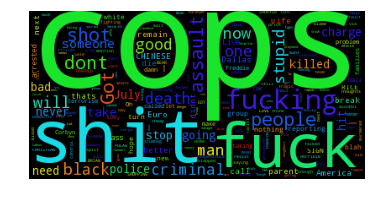

In [191]:
wordcloud = WordCloud().generate(agressive_stringify)
plt.imshow(wordcloud) 
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

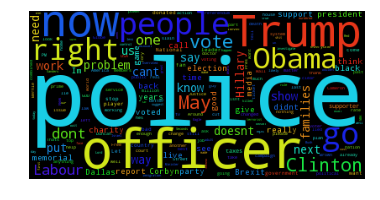

In [198]:
wordcloud = WordCloud().generate(politics_stringify)
plt.imshow(wordcloud) 
plt.axis("off")

In [199]:
sport = [i for row in c.execute("SELECT tweet FROM Twitter_table WHERE category = 'sport' GROUP BY category, tweet") for i in row]
sport_stringify = ''
for i in sport:
    sport_stringify+=i
# turning all the the sport tweets into one big string by adding them altogether
sport_stringify = re.sub('(@|#)(\w+)','', sport_stringify)
sport_stringify = re.sub('(https://)(\w+)','', sport_stringify)
sport_stringify = re.sub('(.co/)(\w+)','', sport_stringify)
sport_stringify = sport_stringify.replace("\'" , "")
sport_stringify = sport_stringify.replace("got" , "").replace('better','').replace('good','')
# using regex to clean the data of irrelevent things such as web links and words that don't matter 

In [200]:
#sport_stringify

(-0.5, 399.5, 199.5, -0.5)

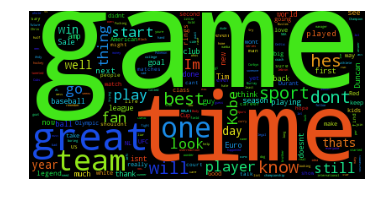

In [201]:
wordcloud = WordCloud().generate(sport_stringify)
plt.imshow(wordcloud) 
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

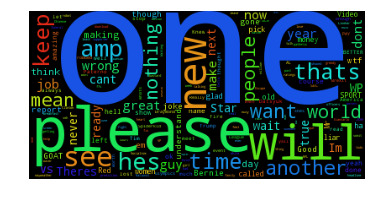

In [202]:
other = [i for row in c.execute("SELECT tweet FROM Twitter_table WHERE category = 'Other' GROUP BY category, tweet") for i in row]
other_stringify = ''
for i in other:
    other_stringify+=i
# turning all the the other tweets into one big string by adding them altogether
other_stringify = re.sub('(@|#)(\w+)','', other_stringify)
other_stringify = re.sub('(https://)(\w+)','', other_stringify)
other_stringify = re.sub('(.co/)(\w+)','', other_stringify)
other_stringify = other_stringify.replace("\'" , "").replace('Cubs','').replace('better','')
# using regex to clean the data of irrelevent things such as web links and words that don't matter 
wordcloud = WordCloud().generate(other_stringify)
plt.imshow(wordcloud) 
plt.axis("off")

# MongoDB Code:

In [78]:
class MyMongoStreamer(TwythonStreamer):
    '''
    
    input: Streaming Data from Twython
    Output: Categorized tweets stored in a Mongo Database
    
    '''
    
    def on_success(self, data):

        if 'text' in data:
            try:
                
                text = data['text'].encode('ascii' ,"ignore" ).encode('utf-8','ignore')
                name = data['entities']['user_mentions'][0]['screen_name']
                location = data['user']['location']
                timestamp = data['created_at']
                # features that I wanted to collect
                
            except IndexError:
                text = data['text'].encode('ascii' ,"ignore" ).encode('utf-8','ignore')
                name = 'None'
                location = data['user']['location']
                timestamp = data['created_at']
                # if I get an indexerror, I would use this instead.
                
            
            # dealing with the unicode
            if text[:2] != 'RT':
                #getting rid of retweets
                
                tweet =(sc.parallelize(str(text).split(' '))
                        .map(lambda word: removePunctuation(word))
                        .map(lambda word : stemmer.stem(word)).collect())
                # bag of words with pyspark and stemming with nltk

                violence_ = len(set(tweet).intersection(violence_words)) / len(set(tweet).union(violence_words))
                sport_ = len(set(tweet).intersection(sport_words)) / len(set(tweet).union(sport_words))
                business_and_politics_ = len(set(tweet).intersection(politicsbusiness_)) / len(set(tweet).union(politicsbusiness_))
                # doing a jaccard index with the 3 different categories
                
                d = {'agressive': violence_ , 'sport': sport_ , 'politics':business_and_politics_}
                if sum(d.values()) == 0.0:
                    #if there is no score in any of the categories, it is categorized as other
                    db.Twitterdb.insert_one({ "timestamp":timestamp, "Other":text , 'name':name , 'location' :location}).inserted_id
                    # inserting into mongodb including id

                else:
                    db.Twitterdb.insert_one(({"timestamp":timestamp,max(d, key=d.get):text, 'name':name , 'location' :location})).inserted_id
                    # category with the highest jaccard index score will be named with the max function
                    # inserting into mongodb including id
                    

    def on_error(self, status_code, data):
        print (status_code)

### Before you stream...type mongod in a bash terminal

In [84]:

# twitter authorization keys

 
try:
    stream = MyMongoStreamer(APP_KEY, APP_SECRET,
                  OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    
    stream.statuses.filter(follow=twitter_id.keys())
    # I have accounts from all the major news and and sports outlets such as reuters, ccn, nbc, bbc, espn,
    # sports illustrated, yahoo, yahoo sports
    
except:
    KeyboardInterrupt
# only way to end this stream is to hit stop

# what is in my mongodb first 10

In [20]:
for item in db.Twitterdb.find()[:10]:
    print (item)

{u'timestamp': u'Wed Jul 13 06:26:19 +0000 2016', u'_id': ObjectId('5785df0e4ea46115eba7c448'), u'sport': u'@SkyNewsBreak @OwenJones84 good luck', u'name': u'SkyNewsBreak', u'location': None}
{u'timestamp': u'Wed Jul 13 06:27:20 +0000 2016', u'_id': ObjectId('5785df494ea46115eba7c449'), u'sport': u'@SportsCenter why. There nba players should be making free throws getting paid millions #smh', u'name': u'SportsCenter', u'location': None}
{u'timestamp': u'Wed Jul 13 06:27:28 +0000 2016', u'_id': ObjectId('5785df504ea46115eba7c44a'), u'Other': u'@BBCBreaking @BBCNews @ashens', u'name': u'BBCBreaking', u'location': None}
{u'politics': u'@BBCBreaking ready to suck cock as per !!!!  Stick a tory prick in there someone !  He,s gagging !!!  Theres plenty of them to choose from.', u'timestamp': u'Wed Jul 13 06:27:28 +0000 2016', u'_id': ObjectId('5785df514ea46115eba7c44b'), u'location': None, u'name': u'BBCBreaking'}
{u'timestamp': u'Wed Jul 13 06:27:45 +0000 2016', u'_id': ObjectId('5785df624ea

# mongo search example

In [105]:
from bson.objectid import ObjectId
print (db.Twitterdb.find_one({u'_id': ObjectId('5785df624ea46115eba7c44c')}))
print (db.Twitterdb.find_one({u'_id': ObjectId('5785e01e4ea46115eba7c453')}))
print (db.Twitterdb.find_one({u'_id': ObjectId('5785e0d24ea46115eba7c45f')}))
#using objectID

{u'timestamp': u'Wed Jul 13 06:27:45 +0000 2016', u'_id': ObjectId('5785df624ea46115eba7c44c'), u'sport': u'@BBCSport  why is everyone so shocked @celticfc are rubbish, they win a title every year in an abysmal league, thinking their a great team!!', u'name': u'BBCSport', u'location': None}
{u'politics': u'@BBCNews if I were Theresa May I would call a GE now....the last time Labour was this unelectable was under Kinnock..', u'timestamp': u'Wed Jul 13 06:30:54 +0000 2016', u'_id': ObjectId('5785e01e4ea46115eba7c453'), u'location': None, u'name': u'BBCNews'}
{u'politics': u'@BBCNews dilutes the votes between the 2 nobodies, Corbyn gets another easy win even with the latest fraudulent voting tactic. #CorbynStays', u'timestamp': u'Wed Jul 13 06:33:53 +0000 2016', u'_id': ObjectId('5785e0d24ea46115eba7c45f'), u'location': u'Fuck the Tory Cunts!', u'name': u'BBCNews'}


In [86]:
for item in db.Twitterdb.find({'sport': { '$regex' : 'win'}}):
    print (item)

{u'timestamp': u'Wed Jul 13 06:27:45 +0000 2016', u'_id': ObjectId('5785df624ea46115eba7c44c'), u'sport': u'@BBCSport  why is everyone so shocked @celticfc are rubbish, they win a title every year in an abysmal league, thinking their a great team!!', u'name': u'BBCSport', u'location': None}
{u'timestamp': u'Wed Jul 13 22:23:01 +0000 2016', u'_id': ObjectId('5786bf574ea461034306fdfd'), u'sport': u".@espn on #Periscope: We're live at the #ESPYS with reigning @GreyGoose Best Male Athlete winner Steph Curry. https://t.co/5paoJNrtPx", u'name': u'espn', u'location': u'TwitterHQ'}
{u'timestamp': u'Wed Jul 13 22:34:37 +0000 2016', u'_id': ObjectId('5786c1fe4ea461034306fe30'), u'sport': u"@CBSNews you don't need a poll for that you created it but consistently showing the negative", u'name': u'CBSNews', u'location': None}


In [102]:
for item in db.Twitterdb.find({'$or': [{'politics': { '$regex' : 'HillaryClinton'}},{'politics': { '$regex' : 'May'}}]}):
    print (item)

{u'politics': u'@BBCNews if I were Theresa May I would call a GE now....the last time Labour was this unelectable was under Kinnock..', u'timestamp': u'Wed Jul 13 06:30:54 +0000 2016', u'_id': ObjectId('5785e01e4ea46115eba7c453'), u'location': None, u'name': u'BBCNews'}
{u'politics': u'State Department plans to review and release unseen @HillaryClinton emails: https://t.co/pTv3rMD3a3 https://t.co/XdHVf0vbHX', u'timestamp': u'Wed Jul 13 22:15:07 +0000 2016', u'_id': ObjectId('5786bd6c4ea461034306fdf5'), u'location': u'New York, NY', u'name': u'HillaryClinton'}


In [31]:
#easy way to search for all
for item in db.Twitterdb.find({'sport': { '$regex' :""}})[:10]:
    print (item)

{u'timestamp': u'Wed Jul 13 06:26:19 +0000 2016', u'_id': ObjectId('5785df0e4ea46115eba7c448'), u'sport': u'@SkyNewsBreak @OwenJones84 good luck', u'name': u'SkyNewsBreak', u'location': None}
{u'timestamp': u'Wed Jul 13 06:27:20 +0000 2016', u'_id': ObjectId('5785df494ea46115eba7c449'), u'sport': u'@SportsCenter why. There nba players should be making free throws getting paid millions #smh', u'name': u'SportsCenter', u'location': None}
{u'timestamp': u'Wed Jul 13 06:27:45 +0000 2016', u'_id': ObjectId('5785df624ea46115eba7c44c'), u'sport': u'@BBCSport  why is everyone so shocked @celticfc are rubbish, they win a title every year in an abysmal league, thinking their a great team!!', u'name': u'BBCSport', u'location': None}
{u'timestamp': u'Wed Jul 13 06:33:51 +0000 2016', u'_id': ObjectId('5785e0d04ea46115eba7c45d'), u'sport': u'@cnnbrk the lil kid throws a temper tantrum again.', u'name': u'cnnbrk', u'location': None}
{u'timestamp': u'Wed Jul 13 07:04:26 +0000 2016', u'_id': ObjectId('

In [54]:
#db.Twitterdb.delete_many({})

# deletes the entire collection

Sources:

Johnathan Dinu's Lesson on Spark:

https://github.com/hopelessoptimism/data-scientists-guide-apache-spark

BBC datasets:

http://mlg.ucd.ie/datasets/bbc.html

Web Scraping with Beautiful Soup:


http://web.stanford.edu/~zlotnick/TextAsData/Web_Scraping_with_Beautiful_Soup.html

http://dscience.co.uk/using-python-for-web-scraping-and-data-collection/

http://stackoverflow.com/questions/22240253/article-scraping-with-beautifulsoup-scraping-all-p-tags

http://stackoverflow.com/questions/3224268/python-unicode-encode-error

http://askubuntu.com/questions/352198/reading-all-files-from-a-directory

SQLite3:

https://docs.python.org/2/library/sqlite3.html

http://stackoverflow.com/questions/22984370/save-utf-8-strings-into-sqlite-table-with-python-sqlite3-module

http://stackoverflow.com/questions/2092757/python-and-sqlite-insert-into-table

Twython:

https://twython.readthedocs.io/en/latest/api.html

http://pythoncentral.io/how-to-use-the-twython-twitter-python-library/

http://stackoverflow.com/questions/29171575/twython-getting-tweets-from-user

https://github.com/ryanmcgrath/twython

http://www.nltk.org/howto/twitter.html

http://h6o6.com/2013/03/using-python-and-the-nltk-to-find-haikus-in-the-public-twitter-stream/

TimeStamps:

http://stackoverflow.com/questions/13890935/does-pythons-time-time-return-the-local-or-utc-timestamp

Timer:

http://stackoverflow.com/questions/5890304/stopwatch-in-python

WordClouds:

https://github.com/amueller/word_cloud

Mongo:

https://pypi.python.org/pypi/pymongo

http://stats.seandolinar.com/collecting-twitter-data-storing-tweets-in-mongodb/

https://api.mongodb.com/python/current/tutorial.html

https://docs.mongodb.com/getting-started/python/remove/

http://www.hacksparrow.com/the-mongodb-tutorial.html

Ipython Image:

http://stackoverflow.com/questions/11854847/display-an-image-from-a-file-in-an-ipython-notebook

